In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
from itertools import islice
from datasets import load_dataset

from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader
import os


In [ ]:
import sentencepiece as spm
import torch

class SentencePieceTokenizer:
    def __init__(self, model_path, max_length=1024):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.max_length = max_length
        self.pad_id = self.sp.pad_id()
        self.bos_id = self.sp.bos_id()
        self.eos_id = self.sp.eos_id()
        self.unk_id = self.sp.unk_id()

    def __call__(self, texts, truncation=True, padding="max_length", return_tensors="pt"):
        token_ids = []
        for text in texts:
            ids = self.sp.encode(text, out_type=int)
            if truncation:
                ids = ids[:self.max_length]
            if padding == "max_length":
                ids += [self.pad_id] * (self.max_length - len(ids))
            token_ids.append(ids)
        return {"input_ids": torch.tensor(token_ids)}


In [ ]:
context_len = 1024
batch_size = 8
n_steps = 1000

# # === Tokenizer ===
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token

tokenizer = SentencePieceTokenizer("/content/drive/MyDrive/c4_spm_8000_final.model", max_length=1024)


# === Load pre-cached deterministic datasets ===
def load_cached_dataset(cache_path):
    if not os.path.exists(cache_path):
        raise FileNotFoundError(f"Cached dataset not found at: {cache_path}")
    print(f"[Dataset] Loading cached dataset from {cache_path}...")
    return torch.load(cache_path, weights_only=False)

train_dataset = load_cached_dataset("/content/drive/MyDrive/cached_train_sp.pt")
val_dataset = load_cached_dataset("/content/drive/MyDrive/cached_val_sp.pt")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


[Dataset] Loading cached dataset from /content/drive/MyDrive/cached_train_sp.pt...
[Dataset] Loading cached dataset from /content/drive/MyDrive/cached_val_sp.pt...


In [ ]:
import torch
import torch.nn.functional as F
from typing import Tuple, Optional, Dict
import math
from cvmm import cvmm, cvmm_prepare_sel2, CVMMSel
from dataclasses import dataclass


@dataclass
class AttentionMask:
    src_length_mask: Optional[torch.Tensor]
    position_mask: Optional[torch.Tensor]


def log_mean(x: torch.Tensor, dim: int = 0):
    return x.logsumexp(dim) - math.log(x.shape[dim])


def entropy_l(l: torch.Tensor) -> torch.Tensor:
    return - (l * l.exp()).sum(-1)


# def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
#     sel = F.log_softmax(sel, dim=dim)
#     log_mean = torch.logsumexp(sel, dim=dim) - math.log(sel.shape[dim])
#     return -(log_mean.exp() * log_mean).sum(-1).mean()

def entropy_reg(sel: torch.Tensor, dim: int) -> torch.Tensor:
    probs = F.softmax(sel, dim=dim)
    log_probs = F.log_softmax(sel, dim=dim)
    entropy = -(probs * log_probs).sum(dim=-1)
    return entropy.mean()

KVCache = Optional[Dict[str, torch.Tensor]]
MultilayerKVCache = Optional[Dict[int, KVCache]]


@dataclass
class MoEUTOutput:
    outputs: torch.Tensor
    reg_loss: torch.Tensor
    cache: MultilayerKVCache


class SigmaMoE(torch.nn.Module):
    def __init__(self, dmodel: int, n_experts: int, expert_size: int, k: int,
                 activation=F.relu,
                 v_dim: Optional[int] = None,
                 expert_dropout: float = 0.0):

        super().__init__()
        self.k_dim = dmodel
        self.v_dim = v_dim if v_dim is not None else dmodel
        self.n_experts = n_experts
        self.expert_size = expert_size
        self.size = self.n_experts * self.expert_size
        self.k_vec_dim = self.k_dim
        self.n_heads = k
        self.activation = activation
        self.expert_dropout = expert_dropout

        self.sel_hist = []

        self.keys = torch.nn.Parameter(torch.empty(self.n_experts, self.k_vec_dim, self.expert_size))
        self.values = torch.nn.Parameter(torch.empty(self.n_experts, self.expert_size, self.v_dim))
        self.expert_sel = torch.nn.Parameter(torch.empty(self.n_experts, self.k_vec_dim))

    @torch.no_grad
    def reset_parameters(self, std_scale: float):
        torch.nn.init.normal_(self.expert_sel, 0, std_scale / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.keys, 0, std_scale / math.sqrt(self.k_dim))
        torch.nn.init.normal_(self.values, 0, std_scale / math.sqrt(self.n_experts * self.expert_size))

        self.renorm_keep_std(self.expert_sel, dim=1)

    def renorm_keep_std(self, weight: torch.Tensor, dim: int = 0):
        with torch.no_grad():
            std = weight.std()
            weight.div_(weight.norm(dim=dim, keepdim=True))
            weight.mul_(std / weight.std())

    def get_reg_loss(self) -> torch.Tensor:
        # print(f"[DEBUG] MoEsigma sel_hist len: {len(self.sel_hist)}")

        if not self.sel_hist:
            return 0

        # Average over time and layers.
        # loss = entropy_reg(torch.stack(self.sel_hist, dim=-2).flatten(-3, -2), -2)
        loss = entropy_reg(torch.stack(self.sel_hist, dim=0).flatten(0, -2), -1)

        self.sel_hist = []
        return loss

    def forward(self, input: torch.Tensor, sel_input: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        # Selection score calculation
        sel = F.linear(sel_input if sel_input is not None else input, self.expert_sel, None)
        if self.training:
            self.sel_hist.append(sel)

        # Selection activation and topk
        sel = F.sigmoid(sel)

        if self.training and self.expert_dropout > 0:
            mask = torch.rand_like(sel) < self.expert_dropout
            sel = sel.masked_fill(mask, float("-inf"))

        sel_val, sel_index = sel.topk(self.n_heads, dim=-1, sorted=False)

        # Preprocess the selection indices. They will be needed for both layers and save some time
        sel_indices = cvmm_prepare_sel2(sel_index.int())

        # "Up-projection" layer for each head
        scores = cvmm(input, sel_indices, self.keys)
        scores = self.activation(scores)

        # Down projection layer for each head
        sel_indices = sel_indices.clone()
        sel_indices.reduction_weight = sel_val
        sel_indices.sel_index = sel_indices.out_index
        sel_indices.out_index = None

        out = cvmm(scores, sel_indices, self.values)

        res = out.view(*input.shape[:-1], self.v_dim)
        return res


class SwitchHeadCore(torch.nn.Module):
    def __init__(self, state_size: int, n_heads: int, n_experts: int, dropout: float = 0.0,
                 projection_size: Optional[int] = None, expert_dropout: float = 0.0, moe_k: int = 2):

        super().__init__()

        self.input_size = state_size
        self.output_size = state_size
        self.pe_size = self.input_size
        self.expert_dropout = expert_dropout
        self.moe_k = moe_k
        self.attention_to_visualize = []
        self.selections_to_visualize = {}
        self.n_experts = n_experts

        self.sel_hist = []

        self.n_heads = n_heads
        self.dropout = torch.nn.Dropout(dropout) if dropout > 0 else torch.nn.Identity()
        self.projection_size = projection_size or (state_size // n_heads)

        self.q = torch.nn.Linear(self.input_size, self.projection_size * self.n_heads, bias=False)
        self.k = torch.nn.Linear(self.input_size, self.projection_size * self.n_heads, bias=False)

        if self.n_experts > 1:
            self.v = torch.nn.Parameter(torch.empty(self.n_heads * self.n_experts, self.input_size, self.projection_size))
            self.o = torch.nn.Parameter(torch.empty(self.n_heads * self.n_experts, self.projection_size, self.output_size))
            self.sel_v = torch.nn.Parameter(torch.empty(self.n_heads * self.n_experts, self.input_size))
        else:
            self.v = torch.nn.Parameter(torch.empty(self.n_heads * self.projection_size, self.input_size))
            self.o = torch.nn.Parameter(torch.empty(self.output_size, self.n_heads * self.projection_size))

        self.sel_o = torch.nn.Parameter(torch.empty(self.n_heads * self.n_experts, self.input_size))

        self.register_buffer("scale", torch.full([1], 1.0 / math.sqrt(self.projection_size)), persistent=False)

    @torch.no_grad
    def reset_parameters(self, std_scale: float):
        if self.n_experts > 1:
            torch.nn.init.normal_(self.sel_v, 0, std_scale / math.sqrt(self.input_size))
            self.renorm_rows(self.sel_v)

        torch.nn.init.normal_(self.sel_o, 0, std_scale / math.sqrt(self.input_size))
        self.renorm_rows(self.sel_o)

        torch.nn.init.normal_(self.k.weight, 0, std_scale / math.sqrt(self.input_size))
        torch.nn.init.normal_(self.q.weight, 0, std_scale / math.sqrt(self.input_size))
        torch.nn.init.normal_(self.v, 0, std_scale / math.sqrt(self.input_size))
        torch.nn.init.normal_(self.o, 0, std_scale / math.sqrt(self.n_heads * self.projection_size))

    def renorm_rows(self, x: torch.Tensor):
        with torch.no_grad():
            std_t = x.std(dim=-1, keepdim=True)
            x.div_(x.norm(dim=-1, keepdim=True))
            x.mul_(std_t / x.std())

    def project_to_torch_order(self, x: torch.Tensor):
        return x.view(*x.shape[:-1], self.n_heads, -1).transpose(-2, -3)

    def get_mask_tensor(self, src_len: int, mask: Optional[AttentionMask]) -> Optional[torch.Tensor]:
        if mask is None or (mask.position_mask is None and mask.src_length_mask is None):
            return None

        # mask.position_mask: [..., N_out, N_in]
        # mask.src_length_mask: [B, ...., N_in]
        # True where it has to be masked

        if mask.position_mask is not None:
            n_pad = src_len - mask.position_mask.shape[-1]
            if n_pad > 0:
                pm = F.pad(mask.position_mask, (n_pad, 0), 'constant', value=False)
            else:
                pm = mask.position_mask

        if mask.position_mask is None:
            m = mask.src_length_mask.unsqueeze(-2).unsqueeze(-2)
        elif mask.src_length_mask is None:
            m = pm
        else:
            m = mask.src_length_mask.unsqueeze(-2).unsqueeze(-2) | pm

        return m

    def get_sel(self, t: torch.Tensor, w: torch.Tensor) -> Tuple[CVMMSel, torch.Tensor]:
        sel = F.linear(t, w).float()
        sel = sel_raw = sel.view(*sel.shape[:-1], self.n_heads, -1)
        sel = sel.sigmoid()

        with torch.no_grad():
            if self.expert_dropout > 0 and self.training:
                mask = torch.rand_like(sel) < self.expert_dropout
                sel2 = sel.masked_fill(mask, float('-inf'))
            else:
                sel2 = sel
            _, sel_index = sel2.topk(self.moe_k, dim=-1, sorted=False)
        sel_val = torch.gather(sel, -1, sel_index)

        sel_index_shifted = (torch.arange(self.n_heads, device=sel_index.device, dtype=sel_index.dtype) * self.n_experts).unsqueeze(-1) + sel_index
        return cvmm_prepare_sel2(sel_index_shifted.flatten(-2,-1), sel_val), sel_raw

    def attend(self, pos_offset: int, v: torch.Tensor, k: torch.Tensor, q: torch.Tensor,
               mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError()

    def get_reg_loss(self) -> torch.Tensor:
        # print(f"[DEBUG] SwitchHeadCore sel_hist len: {len(self.sel_hist)}")
        loss = 0
        if self.sel_hist:
            for i in range(len(self.sel_hist[0])):
                loss = loss + entropy_reg(torch.stack([l[i] for l in self.sel_hist], dim=-3).flatten(-4,-3), -3)
        self.sel_hist = []
        return loss

    def forward(self, q_src: torch.Tensor, k_src: torch.Tensor, v_src: torch.Tensor, mask: Optional[AttentionMask],
                kv_cache: KVCache = None) -> Tuple[torch.Tensor, KVCache]:
        # *src: [batch_size, out_len, c]
        # print(f"[FORWARD] sel_hist size: {len(self.sel_hist)}  | training={self.training}")

        pos_offset = q_src.shape[1] - k_src.shape[1]
        assert pos_offset >= 0

        scale = self.scale.sqrt()

        q = self.q(q_src)
        k = self.k(k_src)
        q = q * scale.type_as(q)
        k = k * scale.type_as(k)

        if self.n_experts > 1:
            v_sel, v_sel_r = self.get_sel(k_src, self.sel_v)
            o_sel, o_sel_r = self.get_sel(q_src, self.sel_o)
            if self.training:
                self.sel_hist.append((o_sel_r, v_sel_r))

            v = cvmm(v_src, v_sel, self.v).transpose(-2, -3)
        else:
            o_gate = F.sigmoid(F.linear(q_src, self.sel_o))
            v = self.project_to_torch_order(F.linear(v_src, self.v))

        q = self.project_to_torch_order(q)
        k = self.project_to_torch_order(k)

        if kv_cache is not None:
            v = torch.cat([kv_cache["v"], v], dim=-2) if "v" in kv_cache else v
            k = torch.cat([kv_cache["k"], k], dim=-2) if "k" in kv_cache else k
            kv_cache = {
                "v": v,
                "k": k
            }

        q = self.dropout(q)
        res = self.attend(pos_offset, v, k, q, self.get_mask_tensor(v.shape[-2], mask))
        res = res.transpose(-2, -3)

        if self.n_experts > 1:
            # The output selection indices are calculated from the current state and are also used for projecting "q".
            # But that projection needs to create multiple copies for the different heads. Here we already have the
            # heads, but we have to create copies for the top-k elements. We can calculate that from the reduction
            # weight. We also want to compute not only the weighted average between the top-k elements, but also
            # of the different heads. So reshape the reduction weight accordingly.
            o_sel.sel_index = o_sel.out_index // o_sel.reduction_weight.shape[-1]
            o_sel.reduction_weight = o_sel.reduction_weight.flatten(-2)
            out = cvmm(res, o_sel, self.o)
        else:
            res = res * o_gate[..., None]
            out = F.linear(res.flatten(-2), self.o)

        return out, kv_cache


class RotaryPosEncoding(torch.nn.Module):
    # RoPE based on: https://www.kaggle.com/code/aeryss/rotary-postional-encoding-rope-pytorch
    def __init__(self, d_model: int, base=10000, seq_dim: int = 1):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, d_model, 2).float() / d_model))
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        self.seq_len_cached = 0
        self.cos_cached = None
        self.sin_cached = None
        self.seq_dim = seq_dim

    def rotate_half(self, x: torch.Tensor) -> torch.Tensor:
        x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
        return torch.cat(
            (-x2, x1), dim=x1.ndim - 1
        )  # dim=-1 triggers a bug in torch < 1.8.0

    def apply_rot(self, x: torch.Tensor, sin: torch.Tensor, cos: torch.Tensor, seq_dim: int, offset: int) -> torch.Tensor:
        sin = sin.narrow(seq_dim, offset, x.shape[seq_dim])
        cos = cos.narrow(seq_dim, offset, x.shape[seq_dim])
        return (x * cos) + (self.rotate_half(x) * sin)

    def apply_rotary_pos_emb(self, q: torch.Tensor, k: torch.Tensor, sin: torch.Tensor, cos: torch.Tensor,
                             seq_dim: int, offset: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.apply_rot(q, sin, cos, seq_dim, offset), self.apply_rot(k, sin, cos, seq_dim, 0)

    def get(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        seq_len = x.shape[self.seq_dim]
        if seq_len > self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(x.shape[self.seq_dim], device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)

            tgt_shape = [1] * x.ndim
            tgt_shape[self.seq_dim] = seq_len
            tgt_shape[-1] = x.shape[-1]

            self.cos_cached = emb.cos().view(*tgt_shape)
            self.sin_cached = emb.sin().view(*tgt_shape)

        return self.sin_cached, self.cos_cached

    def forward(self, q: torch.Tensor, k: torch.Tensor, pos_offset: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
        sin, cos = self.get(k)
        return self.apply_rotary_pos_emb(q, k, sin, cos, self.seq_dim, pos_offset)


class SwitchHeadRope(SwitchHeadCore):
    def __init__(self, state_size: int, n_heads: int, n_experts: int, dropout: float = 0.0,
                 projection_size: Optional[int] = None, expert_dropout: float = 0.0, moe_k: int = 2,
                 rotate_fraction: float = 0.5, rope_base: float = 10000):

        super().__init__(
            state_size, n_heads, n_experts, dropout, projection_size, expert_dropout, moe_k)

        self.n_rotate = math.ceil(rotate_fraction * self.projection_size)
        if self.n_rotate > 0:
            self.pe = RotaryPosEncoding(self.n_rotate, seq_dim=-2, base=rope_base)

    def rotate(self, q: torch.Tensor, k: torch.Tensor, offset: int) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.n_rotate < self.projection_size:
            r_k = k[..., :self.n_rotate]
            nr_k = k[..., self.n_rotate:]
            r_q = q[..., :self.n_rotate]
            nr_q = q[..., self.n_rotate:]

            r_q, r_k = self.pe(r_q, r_k, offset)
            return torch.cat([r_q, nr_q], dim=-1), torch.cat([r_k, nr_k], dim=-1)
        else:
            return self.pe(q, k, offset)

    def attend(self, pos_offset: int, v: torch.Tensor, k: torch.Tensor, q: torch.Tensor,
               mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:

        if self.n_rotate > 0:
            q, k = self.rotate(q, k, pos_offset or 0)

        return F.scaled_dot_product_attention(q, k, v, ~mask, scale=1.0)


class MoEUTLayer(torch.nn.Module):
    def __init__(self, d_model: int, n_heads: int, ff_expert_size: int, ff_n_experts: int,
                 att_n_experts: int, d_head: Optional[int] = None, att_k: int = 2,
                 ff_k: int = 8, ff_expert_dropout: float = 0.0, att_expert_dropout: float = 0.0,
                 dropout: float = 0.0, attention = SwitchHeadRope):

        super().__init__()
        self.attention = attention(
            d_model, n_heads, att_n_experts, projection_size=d_head, moe_k=att_k,
            expert_dropout=att_expert_dropout)
        self.ffn = SigmaMoE(d_model, ff_n_experts, ff_expert_size, k=ff_k, expert_dropout=ff_expert_dropout)
        self.ln1 = torch.nn.LayerNorm(d_model)
        self.ln2 = torch.nn.LayerNorm(d_model)
        self.drop = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: Optional[AttentionMask] = None, kv_cache: KVCache = None) -> Tuple[torch.Tensor, KVCache]:
        xnorm = self.ln1(x)
        att, kv_cache = self.attention(xnorm, xnorm, x, mask, kv_cache=kv_cache)
        x = x + self.drop(att)
        upd = self.ffn(x, self.ln2(x))
        return x + upd, kv_cache


class MoEUT(torch.nn.Module):
    def __init__(self, d_model: int, n_layers: int, n_heads: int, ff_expert_size: int, ff_n_experts: int,
                 att_n_experts: int, d_head: Optional[int] = None, att_k: int = 2,
                 ff_k: int = 8, ff_expert_dropout: float = 0.0, att_expert_dropout: float = 0.0,
                 dropout: float = 0.0, entropy_reg: float = 0.01, att_entropy_reg: float = 0.001,
                 attention = SwitchHeadRope, group_size: int = 2):
        super().__init__()

        self.entropy_reg = entropy_reg
        self.att_entropy_reg = att_entropy_reg

        self.n_repeats = n_layers // group_size
        self.layers = torch.nn.ModuleList([
            MoEUTLayer(d_model, n_heads, ff_expert_size, ff_n_experts, att_n_experts, d_head, att_k, ff_k,
                       ff_expert_dropout, att_expert_dropout, dropout, attention)
            for _ in range(group_size)
        ])

        self.reset_parameters()

    def forward(self, x: torch.Tensor, mask: Optional[AttentionMask] = None,
                kv_cache: MultilayerKVCache = None) -> MoEUTOutput:
        # Run the model
        new_cache = {}
        for r in range(self.n_repeats):
            for li, layer in enumerate(self.layers):
                li_abs = r*len(self.layers)+li
                cache = kv_cache.get(li_abs, {}) if kv_cache is not None else None
                x, new_cache[li_abs] = layer(x, mask, kv_cache = cache)

        # Collect regularizaiton losses. Must be at the end because it is across the layers.
        reg_loss = torch.zeros(1, device=x.device, dtype=torch.float32)
        for layer in self.modules():
            if isinstance(layer, SigmaMoE):
                reg_loss = reg_loss + self.entropy_reg * layer.get_reg_loss()
            elif isinstance(layer, SwitchHeadCore):
                reg_loss = reg_loss + self.att_entropy_reg * layer.get_reg_loss()

        return MoEUTOutput(x, reg_loss, new_cache if kv_cache is not None else None)

    @torch.no_grad
    def reset_parameters(self):
        scale = math.sqrt(2 / (self.n_repeats * len(self.layers)))
        for layer in self.modules():
            if isinstance(layer, (SwitchHeadCore, SigmaMoE)):
                layer.reset_parameters(scale)
            elif isinstance(layer, torch.nn.LayerNorm):
                torch.nn.init.ones_(layer.weight)
                torch.nn.init.zeros_(layer.bias)


class MoEUTLM(torch.nn.Module):
    def __init__(self, n_tokens: int, d_model: int, n_layers: int, n_heads: int,
                 ff_n_experts: int, att_n_experts: int, d_head: Optional[int] = None,
                 group_size: int = 2, ff_k: int = 8,  att_k: int = 2, ff_expert_dropout: float = 0.0,
                 att_expert_dropout: float = 0.0, ff_expert_size: int = 128, dropout: float = 0.0,
                 entropy_reg: float = 0.01, att_entropy_reg: float = 0.001, attention = SwitchHeadRope):

        super().__init__()
        self.transformer = MoEUT(d_model, n_layers, n_heads, ff_expert_size, ff_n_experts, att_n_experts,
                                 d_head, att_k, ff_k, ff_expert_dropout, att_expert_dropout, dropout,
                                 entropy_reg, att_entropy_reg, attention, group_size)

        self.n_layers = n_layers
        self.embedding = torch.nn.Embedding(n_tokens, d_model)
        self.lm_head = torch.nn.Linear(d_model, n_tokens)
        self.out_norm = torch.nn.LayerNorm(d_model)
        self.reset_parameters()

    @torch.no_grad
    def reset_parameters(self):
        torch.nn.init.kaiming_normal_(self.embedding.weight, mode="fan_in", nonlinearity="linear")
        self.transformer.reset_parameters()

    def forward(self, x: torch.Tensor, mask: Optional[AttentionMask] = None,
                kv_cache: MultilayerKVCache = None) -> MoEUTOutput:

        # Input shape: [B, T]
        # kv_cache: feed an empty dict to start caching
        if mask is None:
            mask = AttentionMask(None, self.generate_causal_attention_mask(x.shape[-1]))

        x = self.embedding(x)
        out = self.transformer(x, mask, kv_cache)
        out.outputs = self.lm_head(self.out_norm(out.outputs))
        return out

    def generate_causal_attention_mask(self, sz: int) -> torch.Tensor:
        return torch.triu(torch.ones(sz, sz, dtype=torch.bool, device=self.lm_head.weight.device), diagonal=1)

/content/cvmm.py:402: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("mylib::cvmm_triton", cvmm_triton)


In [ ]:
vocab_size = tokenizer.sp.get_piece_size()
d_model = 412
n_layers = 10
ff_expert_size = 82
dropout = 0.0

config = {
    "n_tokens": vocab_size,
    "d_model": d_model,
    "n_layers": n_layers,
    "n_heads": 4,
    "ff_n_experts": 100,           # From matched pair
    "ff_expert_size": ff_expert_size,
    "ff_k": 4,                    # Top-k routing in FFN
    "att_n_experts": 3,           # Now allows att_k = 2
    # "att_k": 2,
    "dropout": dropout,
    "ff_expert_dropout": 0.0,
    "att_expert_dropout": 0.0,
    "entropy_reg": 0.01,
    "att_entropy_reg": 0.001,
    "group_size": 2               # Reuse blocks as in MoEUT paper
}


In [ ]:

# config = {
#     "n_tokens": tokenizer.vocab_size,
#     "d_model": 412,
#     "n_layers": 6,
#     "n_heads": 4,
#     "ff_n_experts": 10,
#     "ff_expert_size": 82,
#     "ff_k": 4,
#     "dropout": 0.0,
#     "ff_expert_dropout": 0.0,
#     "entropy_reg": 0.01
# }

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.optim.lr_scheduler import CosineAnnealingLR
import time



In [ ]:
n_steps = 1000
eval_every = 1
step = 0
start_time = time.time()

In [ ]:
# --- Model & Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoEUTLM(**config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=n_steps)

In [ ]:
import os
# prefix = "moe"
prefix = "moeut_20m_1000stps"
os.makedirs('/content/drive/MyDrive/sigmamoe', exist_ok=True)
os.makedirs('/content/drive/MyDrive/sigmamoe/checkpoints', exist_ok=True)

# === Checkpointing ===
def save_checkpoint(model, optimizer, step, path=f"/content/drive/MyDrive/sigmamoe/checkpoints/{prefix}.pt"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "step": step
    }, path)
    print(f"[Checkpoint] Saved at step {step} → {path}")

def load_checkpoint(model, optimizer, path=f"/content/drive/MyDrive/sigmamoe/checkpoints/{prefix}.pt"):
    if not os.path.exists(path):
        print("[Checkpoint] No checkpoint found.")
        return 0  # start from scratch

    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    print(f"[Checkpoint] Loaded from {path} at step {ckpt['step']}")
    return ckpt["step"]

In [ ]:
def evaluate(model, val_loader, vocab_size, device):
    # --- Evaluation Function ---
    model.eval()
    total_loss, total_tokens = 0.0, 0
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            out = model(x)
            logits = out.outputs
            reg_loss = out.reg_loss
            ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=tokenizer.pad_id)
            total_loss += (ce_loss.item() + reg_loss.item()) * y.numel()
            total_tokens += y.numel()
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f"[Eval @ step {step}] Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")
    model.train()


def train_sigmoe_on_c4(model, train_loader, val_loader, device, vocab_size, optimizer, num_steps=1000, eval_every=100):
    model.train()
    # step = load_checkpoint(model, optimizer)
    # --- Training ---'
    loss_history = []
    perplexity = []
    for epoch in range(3):

        step = 0
        for batch in train_loader:
            model.train()
            if step >= n_steps:
                break
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            logits = out.outputs
            reg_loss = out.reg_loss
            ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=tokenizer.pad_id)
            total_loss = ce_loss + reg_loss

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)  # gradient clipping
            optimizer.step()
            scheduler.step()
            loss_history.append(total_loss.item())
            perplexity.append(torch.exp(torch.tensor(total_loss.item())).item())

            if step % 10 == 0:
                print(f"[Step {step}] Loss: {ce_loss.item():.4f} + Reg: {reg_loss.item()}")
            if step % eval_every == 0 and step != 0:
                # evaluate(model, val_loader, tokenizer.sp.get_piece_size(), device)
                save_checkpoint(model, optimizer, step)
            step += 1
        if step >= n_steps:
            break

    print(f"Training completed in {(time.time() - start_time)/60:.2f} minutes.")
    return loss_history, perplexity

In [ ]:
print("Training SigmaMoE on C4 (0.1%)...")
loss_history, perplexity = train_sigmoe_on_c4(model, train_loader, val_loader, device, vocab_size, optimizer, num_steps=n_steps)


Training SigmaMoE on C4 (0.1%)...
[Step 0] Loss: 9.1437 + Reg: 0.09028759598731995
[Step 10] Loss: 7.7089 + Reg: 0.08769206702709198
[Step 20] Loss: 7.2615 + Reg: 0.08147525787353516
[Step 30] Loss: 7.3528 + Reg: 0.06520044803619385
[Step 40] Loss: 7.0503 + Reg: 0.03297067806124687
[Step 50] Loss: 6.9220 + Reg: 0.01957402564585209
[Step 60] Loss: 6.9549 + Reg: 0.010703135281801224
[Step 70] Loss: 7.1756 + Reg: 0.003885420272126794
[Step 80] Loss: 6.8744 + Reg: 0.0051546585746109486
[Step 90] Loss: 6.8714 + Reg: 0.00343567063100636
[Step 100] Loss: 6.9329 + Reg: 0.0031290962360799313
[Checkpoint] Saved at step 100 → /content/drive/MyDrive/sigmamoe/checkpoints/moeut_20m_1000stps.pt
[Step 110] Loss: 6.9764 + Reg: 0.0034881746396422386
[Step 120] Loss: 6.8693 + Reg: 0.0020856563933193684
[Step 130] Loss: 7.0075 + Reg: 0.0013748662313446403
[Step 140] Loss: 6.8411 + Reg: 0.0011904683196917176
[Step 150] Loss: 6.9126 + Reg: 0.0009269050788134336
[Step 160] Loss: 6.9684 + Reg: 0.0015055024996

In [ ]:
evaluate(model, val_loader, tokenizer.sp.get_piece_size(), device)

[Eval @ step 0] Loss: 6.9410, Perplexity: 1033.84


In [ ]:
from matplotlib import pyplot as plt

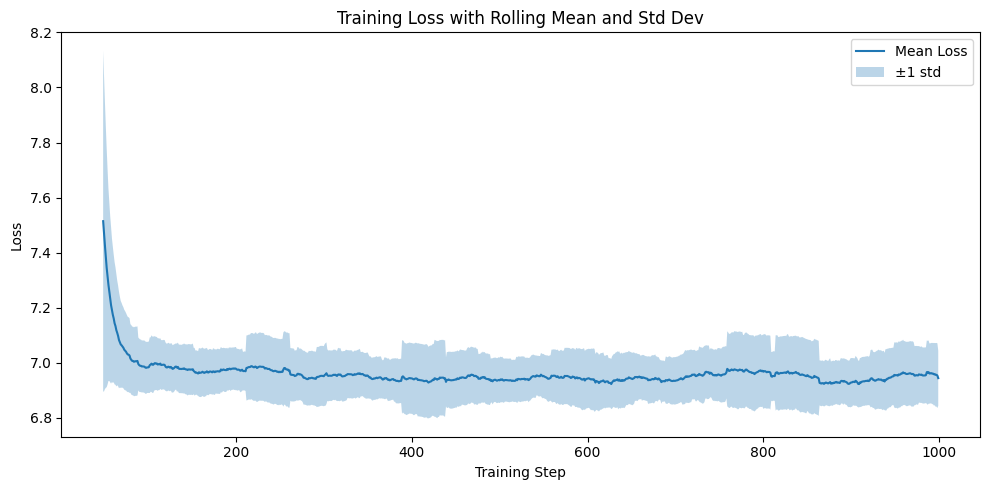

Training completed.


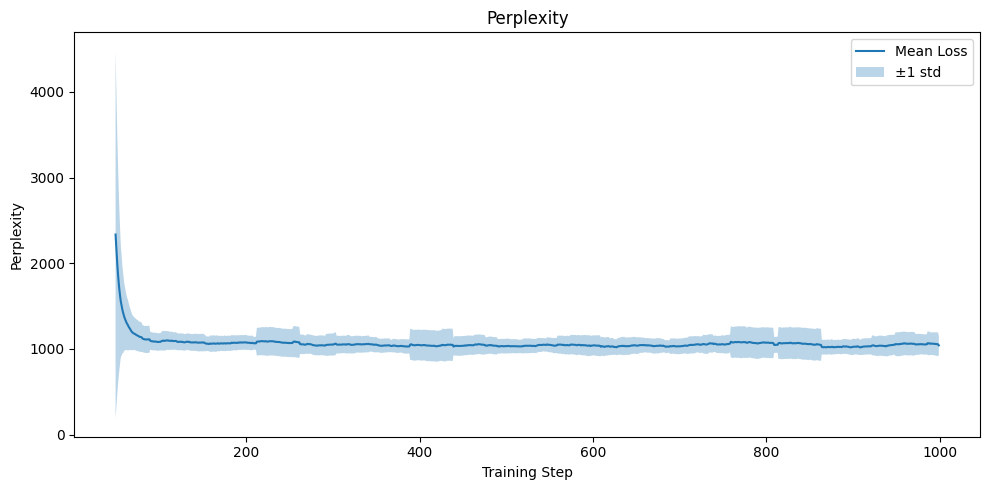

Training completed.


In [ ]:
# Plot loss with rolling mean and std
losses = torch.tensor(loss_history)
window = 50
if len(losses) >= window:
  rolling_mean = losses.unfold(0, window, 1).mean(dim=1)
  rolling_std = losses.unfold(0, window, 1).std(dim=1)
  x_range = range(window - 1, len(losses))

  plt.figure(figsize=(10, 5))
  plt.plot(x_range, rolling_mean, label='Mean Loss')
  plt.fill_between(x_range,
                    rolling_mean - rolling_std,
                    rolling_mean + rolling_std,
                    alpha=0.3, label='±1 std')
  plt.title("Training Loss with Rolling Mean and Std Dev")
  plt.xlabel("Training Step")
  plt.ylabel("Loss")
  plt.legend()
  plt.tight_layout()
  plt.show()

print("Training completed.")


# Plot loss with rolling mean and std
losses = torch.tensor(perplexity)
window = 50
if len(losses) >= window:
  rolling_mean = losses.unfold(0, window, 1).mean(dim=1)
  rolling_std = losses.unfold(0, window, 1).std(dim=1)
  x_range = range(window - 1, len(losses))

  plt.figure(figsize=(10, 5))
  plt.plot(x_range, rolling_mean, label='Mean Loss')
  plt.fill_between(x_range,
                    rolling_mean - rolling_std,
                    rolling_mean + rolling_std,
                    alpha=0.3, label='±1 std')
  plt.title("Perplexity")
  plt.xlabel("Training Step")
  plt.ylabel("Perplexity")
  plt.legend()
  plt.tight_layout()
  plt.show()

print("Training completed.")

In [ ]:
import os
import csv

# Save raw loss values
def save_losses_to_file(losses, filename=f"/content/drive/MyDrive/{prefix}training_loss_log.csv"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "loss"])
        for i, loss in enumerate(zip(losses, perplexity)):
            writer.writerow([i, loss[0], loss[1]])


In [ ]:
save_losses_to_file(loss_history)
